In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import sys

sys.path.append("/home/psa_images/SemiF-AnnotationPipeline")
from utils.utils import trans_cutout
import seaborn as sns
import os
import matplotlib.pyplot as plt

## Load data and preprocess

In [61]:
batch_id = "MD_2023-04-18"
df = pd.read_csv(f"../data/semifield-cutouts/{batch_id}/{batch_id}.csv")
df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
df["temp_path"] = "../data/semifield-cutouts/" + df["cutout_path"]
exclude_columns = [
    'data_root', 'bbox', 'season', 'batch_id', 'image_id', 'cutout_num',
    'cutout_path', 'exif_meta', 'synth', 'EPPO', 'collection_timing',
    'multi_species_USDA_symbol', 'link', 'note', 'hex', 'r', 'g', 'b'
]
df = df.drop(columns=exclude_columns)

# Number of Cutouts (sub-images) by Batch Id

Text(0.5, 0.98, 'Number of Cutouts (sub-images) by Batch Id MD_2023-04-18')

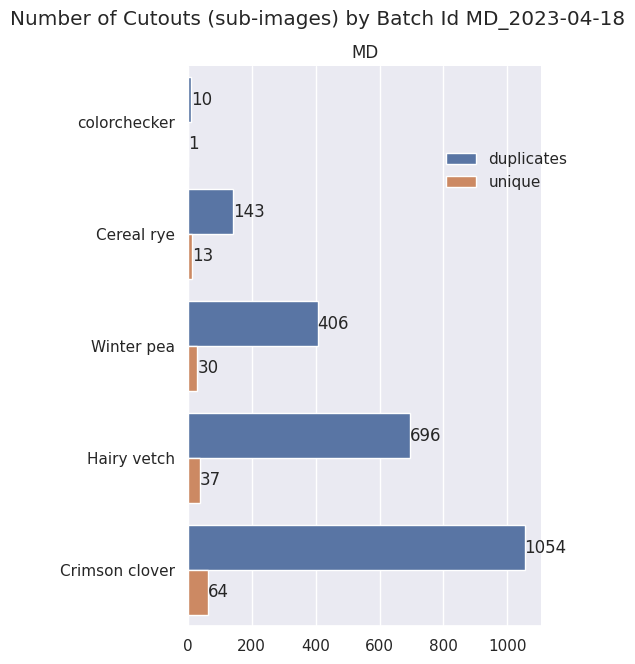

In [62]:
c = df.groupby(["common_name", "state_id", "is_primary"
                ]).cutout_id.count().reset_index().sort_values("cutout_id")
# c = c[c["common_name"] != "colorchecker"]
g = sns.catplot(data=c,
                x="cutout_id",
                y="common_name",
                hue="is_primary",
                orient="horizontal",
                col="state_id",
                sharey=False,
                kind="bar",
                aspect=.8,
                height=7)
g.set(xlabel="", ylabel="")
g.set_titles(col_template="{col_name}")
g._legend.set_title("")
# replace labels
new_labels = ['duplicates', 'unique']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)
sns.move_legend(g, "center right", bbox_to_anchor=(.9, .75), frameon=False)
ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'{(int(v.get_width()))}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
g.fig.suptitle(f'Number of Cutouts (sub-images) by Batch Id {batch_id}')
# g.savefig(f"../assets/Cutouts_for_batch{batch_id}.png", dpi=300)

## Organize important features

In [64]:
features = [
    'datetime', 'cutout_id', 'hwc', 'camera_info', 'is_primary',
    'extends_border', 'cropout_exg_mean', 'cropout_exg_std',
    'cropout_gli_mean', 'cropout_gli_std', 'cropout_r_mean', 'cropout_r_std',
    'cropout_r_skewness', 'cropout_r_kurtosis', 'cropout_r_variance',
    'cropout_g_mean', 'cropout_g_std', 'cropout_g_skewness',
    'cropout_g_kurtosis', 'cropout_g_variance', 'cropout_b_mean',
    'cropout_b_std', 'cropout_b_skewness', 'cropout_b_kurtosis',
    'cropout_b_variance', 'cutout_exg_mean', 'cutout_exg_std',
    'cutout_gli_mean', 'cutout_gli_std', 'cutout_r_mean', 'cutout_r_std',
    'cutout_r_skewness', 'cutout_r_kurtosis', 'cutout_r_variance',
    'cutout_g_mean', 'cutout_g_std', 'cutout_g_skewness', 'cutout_g_kurtosis',
    'cutout_g_variance', 'cutout_b_mean', 'cutout_b_std', 'cutout_b_skewness',
    'cutout_b_kurtosis', 'cutout_b_variance', 'area', 'group', 'class',
    'subclass', 'order', 'family', 'genus', 'species', 'common_name',
    'authority', 'growth_habit', 'axis_major_length', 'axis_minor_length',
    'centroid0', 'centroid1', 'eccentricity', 'solidity', 'perimeter',
    'green_sum', 'blur_effect', 'num_components', 'state_id', 'temp_path'
]
named_featdata = df.loc[:, features]
multfeatdf = named_featdata.groupby(
    ["common_name"]).describe().reset_index()  #names=["common_name"])
multfeatdf = multfeatdf[multfeatdf["common_name"] != "colorchecker"]
multfeatdf
multfeatdf.columns = multfeatdf.columns.to_flat_index()
multfeatdf.columns = [
    '_'.join(x) for x in multfeatdf.columns.get_level_values(0)
]
multfeatdf


,common_name_,cropout_exg_mean_count,cropout_exg_mean_mean,cropout_exg_mean_std,cropout_exg_mean_min,cropout_exg_mean_25%,cropout_exg_mean_50%,cropout_exg_mean_75%,cropout_exg_mean_max,cropout_exg_std_count,...,blur_effect_75%,blur_effect_max,num_components_count,num_components_mean,num_components_std,num_components_min,num_components_25%,num_components_50%,num_components_75%,num_components_max
0,Cereal rye,156.0,16.211773,10.278303,4.082602,7.636690,15.411335,21.025319,64.231514,156.0,...,0.414683,0.518345,156.0,9.448718,7.989747,1.0,3.0,8.0,12.0,38.0
1,Crimson clover,1118.0,40.928559,12.292090,14.642609,31.194985,40.972068,49.857084,72.912047,1118.0,...,0.381959,0.458980,1118.0,8.119857,9.363443,1.0,2.0,5.0,10.0,69.0
2,Hairy vetch,733.0,28.278610,10.019806,7.265839,20.232454,27.864412,35.126231,73.667765,733.0,...,0.366047,0.434520,733.0,37.070941,40.315665,1.0,11.0,25.0,48.0,287.0
3,Winter pea,436.0,32.063763,8.643765,12.589521,25.191184,32.569828,37.954707,57.932773,436.0,...,0.366441,0.496731,436.0,23.566514,30.275633,1.0,4.0,14.0,30.0,218.0


## Cluster map of features

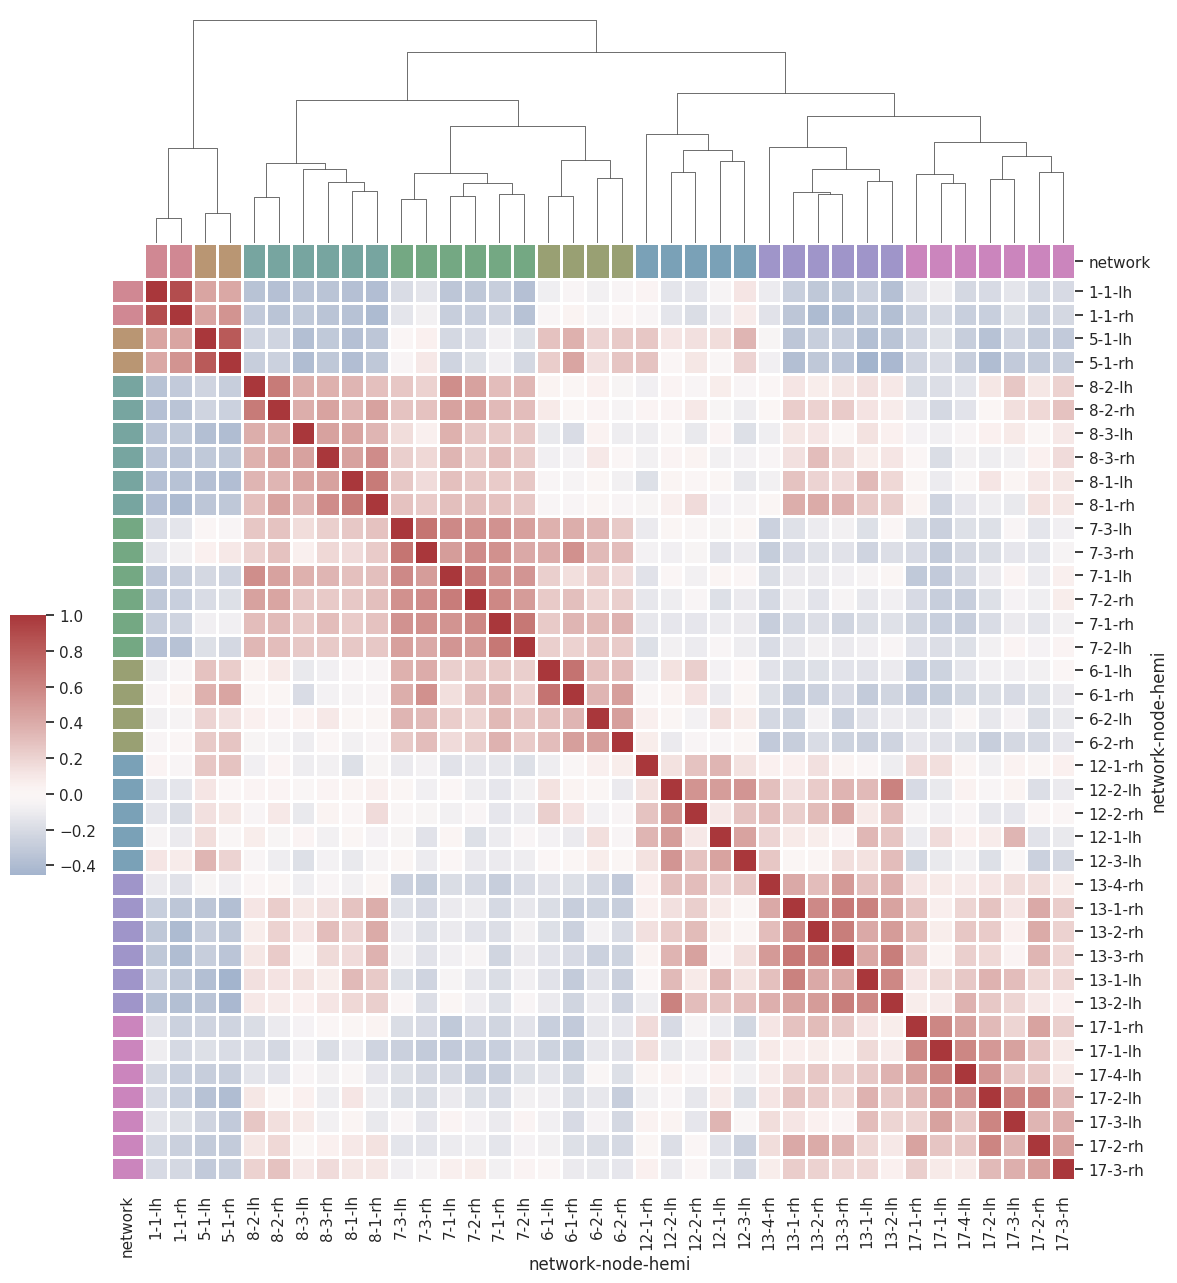

In [67]:
sns.set_theme()

# Load the brain networks example dataset
xdf = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (
    xdf.columns.get_level_values("network").astype(int).isin(used_networks))
xdf = xdf.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = xdf.columns.get_level_values("network")
network_colors = pd.Series(networks, index=xdf.columns).map(network_lut)

# Draw the full plot
g = sns.clustermap(xdf.corr(),
                   center=0,
                   cmap="vlag",
                   row_colors=network_colors,
                   col_colors=network_colors,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.75,
                   figsize=(12, 13))

g.ax_row_dendrogram.remove()

/home/mkutuga/anaconda3/envs/semif/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

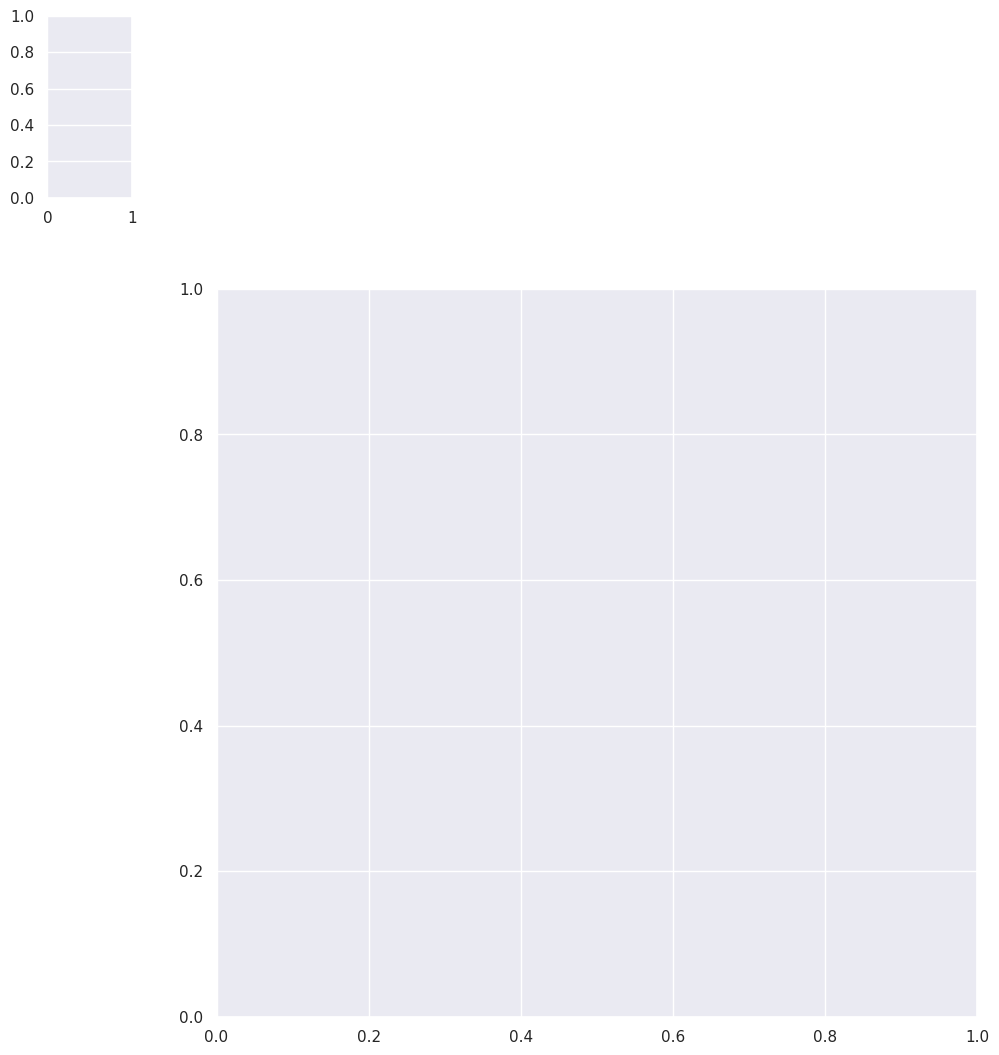

In [94]:
# Create a categorical palette to identify the networks
props_pal = sns.husl_palette(len(features), s=.45)
props_lut = dict(zip(map(str, features), props_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
props = named_featdata.columns.get_level_values(0)
# props_colors = pd.Series(props, index=xdf.columns).map(props_lut)

# Draw the full plot
# Identify the columns with data type 'object' (usually representing strings)
string_columns = multfeatdf.select_dtypes(include=['object']).columns

# Drop those columns
nostdf = multfeatdf.drop(columns=string_columns)
g = sns.clustermap(
    nostdf.corr(),
    center=0,
    cmap="vlag",
    #    row_colors=network_colors,
    #    col_colors=network_colors,
    dendrogram_ratio=(.1, .2),
    cbar_pos=(.02, .32, .03, .2),
    linewidths=.75,
    figsize=(12, 13))


In [101]:
cordf = nostdf.corr()
cordf

,cropout_exg_mean_count,cropout_exg_mean_mean,cropout_exg_mean_std,cropout_exg_mean_min,cropout_exg_mean_25%,cropout_exg_mean_50%,cropout_exg_mean_75%,cropout_exg_mean_max,cropout_exg_std_count,cropout_exg_std_mean,...,blur_effect_75%,blur_effect_max,num_components_count,num_components_mean,num_components_std,num_components_min,num_components_25%,num_components_50%,num_components_75%,num_components_max
cropout_exg_mean_count,1.000000,0.887108,0.685710,0.711868,0.842006,0.870526,0.914374,0.717075,1.000000,0.914684,...,-0.499900,-0.788164,1.000000,0.014003,0.038326,NaN,0.058641,-0.045056,0.010965,0.100001
cropout_exg_mean_mean,0.887108,1.000000,0.414063,0.950851,0.993404,0.999363,0.997868,0.316417,0.887108,0.993096,...,-0.647992,-0.565506,0.887108,-0.017928,0.082943,NaN,-0.140209,-0.136537,-0.025529,0.156116
cropout_exg_mean_std,0.685710,0.414063,1.000000,0.268596,0.306986,0.384877,0.466492,0.737083,0.685710,0.516096,...,0.285629,-0.339812,0.685710,-0.555277,-0.608451,NaN,-0.323340,-0.522985,-0.552461,-0.577401
cropout_exg_mean_min,0.711868,0.950851,0.268596,1.000000,0.959555,0.959129,0.932784,0.021862,0.711868,0.934534,...,-0.572710,-0.295192,0.711868,-0.155847,-0.019174,NaN,-0.355817,-0.294628,-0.165277,0.053537
cropout_exg_mean_25%,0.842006,0.993404,0.306986,0.959555,1.000000,0.996367,0.984653,0.239904,0.842006,0.973274,...,-0.714768,-0.550766,0.842006,0.053431,0.165326,NaN,-0.103213,-0.074508,0.045143,0.237888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
num_components_min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_components_25%,0.058641,-0.140209,-0.323340,-0.355817,-0.103213,-0.146264,-0.129735,0.400963,0.058641,-0.193586,...,-0.519890,-0.659534,0.058641,0.933408,0.859552,NaN,1.000000,0.970725,0.937003,0.837974
num_components_50%,-0.045056,-0.136537,-0.522985,-0.294628,-0.074508,-0.133969,-0.141849,0.188448,-0.045056,-0.213246,...,-0.611667,-0.555562,-0.045056,0.987747,0.946688,NaN,0.970725,1.000000,0.989404,0.926349
num_components_75%,0.010965,-0.025529,-0.552461,-0.165277,0.045143,-0.019670,-0.037219,0.138176,0.010965,-0.111573,...,-0.713556,-0.572206,0.010965,0.999939,0.982981,NaN,0.937003,0.989404,1.000000,0.971219


### Mean cutout pixel area by species

Text(0.5, 0.98, 'Mean cutout pixel area by species')

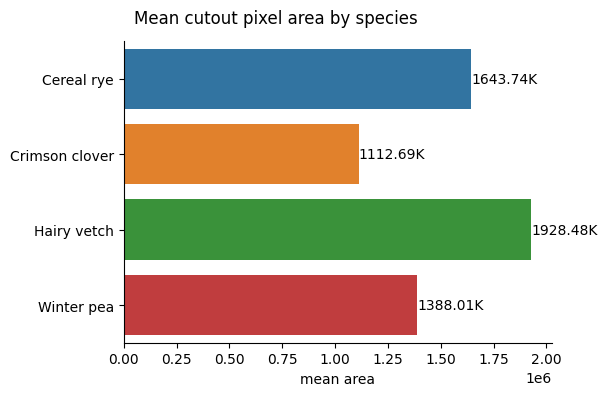

In [47]:
g = sns.catplot(data=multfeatdf,
                x="area_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width() / 1000):.2f}K' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="mean area", ylabel="")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
g.fig.suptitle('Mean cutout pixel area by species')

### Mean green_sum of cutouts by species

Text(0.5, 0.98, 'Mean bbox area of cutouts by speciesa')

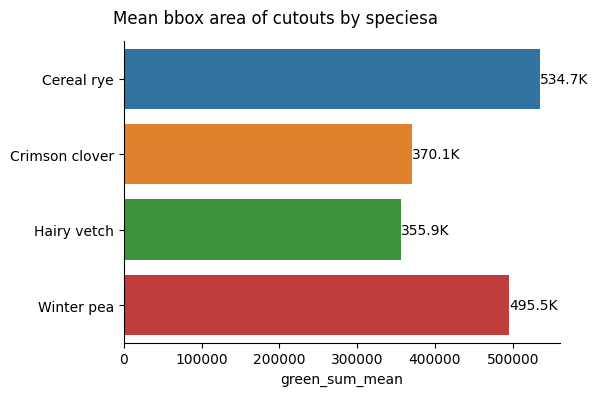

In [48]:
g = sns.catplot(data=multfeatdf,
                x="green_sum_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width()/ 1000):.1f}K' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="green_sum_mean", ylabel="")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
g.fig.suptitle('Mean bbox area of cutouts by speciesa')

### Mean solidity_mean of cutouts by species

Text(0.5, 0.98, 'Mean solidity_mean of cutouts by species')

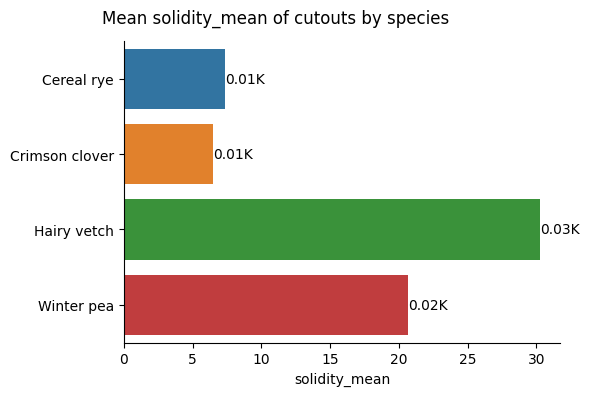

In [49]:
g = sns.catplot(data=multfeatdf,
                x="solidity_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]
# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width() / 1000):.2f}K' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="solidity_mean", ylabel="")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
g.fig.suptitle('Mean solidity_mean of cutouts by species')

Text(0.5, 0.98, 'Mean blur effect of cutouts by species \n(0 for no blur, 1 for maximal blur).')

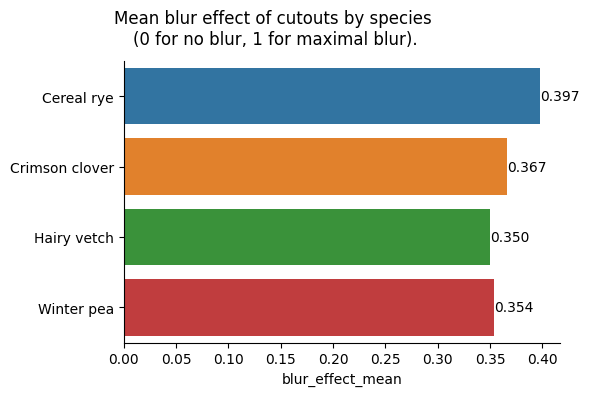

In [32]:
g = sns.catplot(data=multfeatdf,
                x="blur_effect_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="blur_effect_mean", ylabel="")
g.fig.subplots_adjust(top=0.85)  # adjust the Figure in rp
g.fig.suptitle(
    'Mean blur effect of cutouts by species \n(0 for no blur, 1 for maximal blur).'
)


Text(0.5, 0.98, 'Mean number of components or parts of cutouts by species')

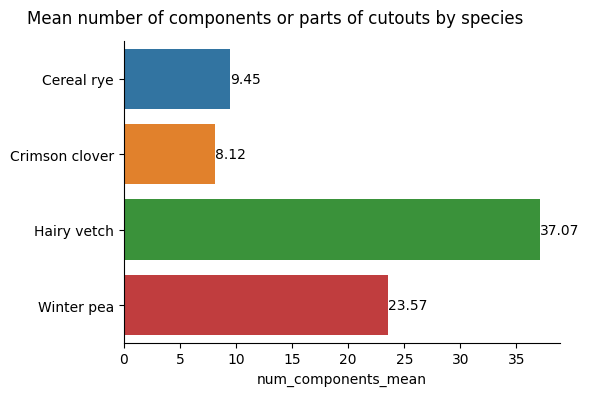

In [33]:
g = sns.catplot(data=multfeatdf,
                x="num_components_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")
# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width()):.2f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="num_components_mean", ylabel="")
g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp
g.fig.suptitle('Mean number of components or parts of cutouts by species')

In [ ]:
g = sns.catplot(data=multfeatdf,
                x="solidity_mean",
                y="common_name_",
                height=4,
                aspect=1.5,
                kind="bar")

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
for c in ax.containers:
    labels = [f'{(v.get_width()):.3f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

g.set(xlabel="solidity_mean", ylabel="")
g.fig.subplots_adjust(top=0.7)  # adjust the Figure in rp
g.fig.suptitle(
    'Mean solidity of cutouts by species\n(Solidity is the ratio of pixels in the objects\n to pixels of the convex hull image.\n It gives a measure of the compactness of the object.)'
)


In [ ]:
df.columns

In [ ]:
df
# sns.violinplot(data=df[df["common_name"]!="colorchecker"], x="common_name", y="area",scale="count",hue="is_primary", split=True,dodge=True)

# Draw a nested violinplot and split the violins for easier comparison
# sns.violinplot(data=df[df["common_name"]!="colorchecker"], x="common_name", y="area", hue="is_primary",
#                split=True, inner="quart", linewidth=1)
# sns.despine(left=True)

sns.boxenplot(
    data=df[df["common_name"] != "colorchecker"],
    x="common_name",
    y="area",
    #   color="b",
    k_depth="trustworthy",
    scale="linear")
